## pytorchにおける転移学習

<ol>
<li>convnetを層の初期値としてチューニング(Fine Tuning)する</li>
<li>convnetを特徴抽出器として利用し、後続に別のネットワークを入れ、学習させる</li>
</ol>

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os

%matplotlib inline

In [2]:
# 画像データの読み込みと標準化
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        # 224*224にランダムにクロップ
        transforms.RandomSizedCrop(224),
            
        # 確率0.5で画像を上下反転させる
        transforms.RandomHorizontalFlip(),
            
        #Tensor化
        transforms.ToTensor(),
        
        #3チャネルを標準化    
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
            
        # 中央部分を224*224にクロップ
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#データの読み込み
data_dir = 'data/hymenoptera_data'
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
         for x in ['train', 'val']}
dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=4,
                                               shuffle=True, num_workers=4)
                for x in ['train', 'val']}
dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}
dset_classes = dsets['train'].classes

use_gpu = torch.cuda.is_available()

In [3]:
#データセットの数
dset_sizes

{'train': 244, 'val': 153}

In [4]:
#クラスの名前
dset_classes

['ants', 'bees']

データ数がトレーニング：244, テスト：153とかなり少ない<br>
この数の少なさを補うためにconvnetを使った転移学習を行う

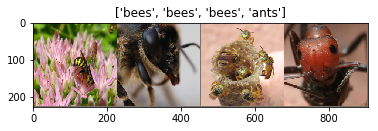

In [5]:
#サンプル画像の表示
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dset_loaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[dset_classes[x] for x in classes])

In [6]:
def train_model(model, criterion, optimizer, lr_scheduler, num_epochs=25):
    since = time.time()

    best_model = model
    best_acc = 0.0

    for epoch in range(num_epochs):
        #開始エポックの表示
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # トレーニングかテストかの指定
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                #optimizerのスケジューラの設定
                optimizer = lr_scheduler(optimizer, epoch)
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dset_loaders[phase]:
                # get the inputs
                inputs, labels = data

                #GPU使用の有無
                # wrap them in Variable
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), \
                        Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = running_corrects / dset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 前より良くなってた時のみモデル更新をする
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return best_model

In [7]:
# learning rateのスケジューラの設定
def exp_lr_scheduler(optimizer, epoch, init_lr=0.001, lr_decay_epoch=7):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (0.1**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer

In [8]:
#予測と画像の表示
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dset_loaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        #予測
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(dset_classes[labels.data[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

## Fine Tuning

In [9]:
#resnetからのモデルの読み込み
model_ft = models.resnet18(pretrained=True)

#最終のfc層を置き換え
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

#GPU利用の有無
if use_gpu:
    model_ft = model_ft.cuda()

#Loss関数の定義
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

In [10]:
#ネットワーク構造の確認
model_ft.parameters

<bound method ResNet.parameters of ResNet (
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU (inplace)
  (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential (
    (0): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock (
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU (inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), b

最終層にfc層がある。そのため、model_ft.fcを呼び出すことで最終層の置き換えができる

In [11]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
LR is set to 0.001
train Loss: 0.1501 Acc: 0.7090
val Loss: 0.1357 Acc: 0.7908

Epoch 1/24
----------
train Loss: 0.1403 Acc: 0.7787
val Loss: 0.1046 Acc: 0.8693

Epoch 2/24
----------
train Loss: 0.1436 Acc: 0.7951
val Loss: 0.0863 Acc: 0.8627

Epoch 3/24
----------
train Loss: 0.1187 Acc: 0.8279
val Loss: 0.0529 Acc: 0.9150

Epoch 4/24
----------
train Loss: 0.1314 Acc: 0.7705
val Loss: 0.2961 Acc: 0.6601

Epoch 5/24
----------
train Loss: 0.1301 Acc: 0.8115
val Loss: 0.2067 Acc: 0.7843

Epoch 6/24
----------
train Loss: 0.1321 Acc: 0.7910
val Loss: 0.1059 Acc: 0.8431

Epoch 7/24
----------
LR is set to 0.0001
train Loss: 0.0994 Acc: 0.8238
val Loss: 0.0629 Acc: 0.9020

Epoch 8/24
----------
train Loss: 0.0687 Acc: 0.8648
val Loss: 0.0568 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.0673 Acc: 0.8730
val Loss: 0.0577 Acc: 0.9020

Epoch 10/24
----------
train Loss: 0.0781 Acc: 0.8566
val Loss: 0.0602 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.0645 Acc: 

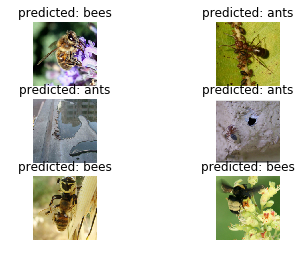

In [12]:
visualize_model(model_ft)

## レイヤーのフリーズ

In [10]:
model_conv = torchvision.models.resnet18(pretrained=True)

#プレトレーニング済のモデルのフリーズ
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

In [11]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
LR is set to 0.001
train Loss: 0.1723 Acc: 0.6148
val Loss: 0.0892 Acc: 0.8693

Epoch 1/24
----------
train Loss: 0.1380 Acc: 0.7541
val Loss: 0.0748 Acc: 0.8758

Epoch 2/24
----------
train Loss: 0.0929 Acc: 0.8320
val Loss: 0.0469 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.0861 Acc: 0.8484
val Loss: 0.0441 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.1416 Acc: 0.7582
val Loss: 0.0456 Acc: 0.9542

Epoch 5/24
----------
train Loss: 0.1083 Acc: 0.8402
val Loss: 0.0517 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.1223 Acc: 0.7746
val Loss: 0.0524 Acc: 0.9346

Epoch 7/24
----------
LR is set to 0.0001
train Loss: 0.0939 Acc: 0.8402
val Loss: 0.0615 Acc: 0.9281

Epoch 8/24
----------
train Loss: 0.1091 Acc: 0.8238
val Loss: 0.0502 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.0883 Acc: 0.8607
val Loss: 0.0445 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.0747 Acc: 0.8770
val Loss: 0.0472 Acc: 0.9477

Epoch 11/24
----------
train Loss: 0.0790 Acc: 

プレトレーニング済のレイヤーのフリーズで精度が若干向上する

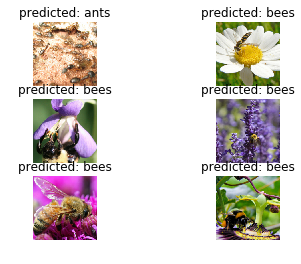

In [12]:
visualize_model(model_conv)

plt.ioff()
plt.show()